## Anime Recommendation System - Data Preprocessing and system development


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('white')
import matplotlib.pyplot as plt
%matplotlib inline
import re
import ipywidgets as widgets
from ipywidgets import interact
from functools import partial

### The dataset
Dataset was downloaded from [Kaggle](https://www.kaggle.com/datasets/hernan4444/anime-recommendation-database-2020)

In [2]:
anime_db = pd.read_csv('./data/MAL.csv')

In [3]:
anime_db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16650 entries, 0 to 16649
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     16650 non-null  int64  
 1   name           16650 non-null  object 
 2   english_name   5166 non-null   object 
 3   type           16650 non-null  object 
 4   episodes       16167 non-null  float64
 5   members        16650 non-null  float64
 6   score_members  0 non-null      float64
 7   rating         11584 non-null  float64
 8   genre          16650 non-null  object 
 9   dates          16650 non-null  object 
 10  url            16650 non-null  object 
dtypes: float64(4), int64(1), object(6)
memory usage: 1.4+ MB


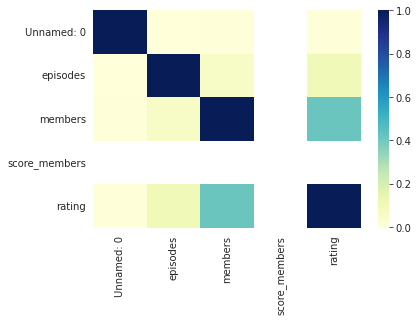

In [4]:
anime_corr_map = sns.heatmap(anime_db.corr(),cmap="YlGnBu")
plt.show()

## Removing unnecessary field "Unnamed: 0"

In [5]:
anime_db = anime_db.drop(["Unnamed: 0"], axis=1)

## Adult content should not be included in our recommendation system.

In [6]:
# search for adult content
sum(anime_db.genre.str.contains('Hentai'))

1209

In [7]:
# drop adult content from the db
anime_db = anime_db.drop(anime_db[anime_db.genre.str.contains('Hentai')].index)

In [8]:
# verify removal
sum(anime_db.genre.str.contains('Hentai'))

0

### Missing data

Check for missing data

In [9]:
#check missing values
anime_db.isnull().sum().sort_values(ascending=False)

score_members    15441
english_name     10600
rating            5046
episodes           438
name                 0
type                 0
members              0
genre                0
dates                0
url                  0
dtype: int64

A couple missing data (identified as NA. Note there could be missing data masked as something else):

- 438 are missing the number of episodes, 
- 5046 do not have ratings

## Drop score_members column as it is not useful

In [10]:
anime_db = anime_db.drop(["score_members"], axis=1)

In [11]:
anime_db.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15441 entries, 0 to 16649
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   name          15441 non-null  object 
 1   english_name  4841 non-null   object 
 2   type          15441 non-null  object 
 3   episodes      15003 non-null  float64
 4   members       15441 non-null  float64
 5   rating        10395 non-null  float64
 6   genre         15441 non-null  object 
 7   dates         15441 non-null  object 
 8   url           15441 non-null  object 
dtypes: float64(3), object(6)
memory usage: 1.2+ MB


In [12]:
anime_db.describe()

,episodes,members,rating
count,15003.000000,1.544100e+04,10395.000000
mean,12.412717,3.183351e+04,6.601014
std,50.262130,1.070111e+05,0.891502
min,1.000000,1.900000e+01,1.890000
25%,1.000000,2.770000e+02,6.040000
50%,1.000000,1.681000e+03,6.620000
75%,12.000000,1.444500e+04,7.240000
max,3057.000000,2.074444e+06,9.230000


<AxesSubplot:>

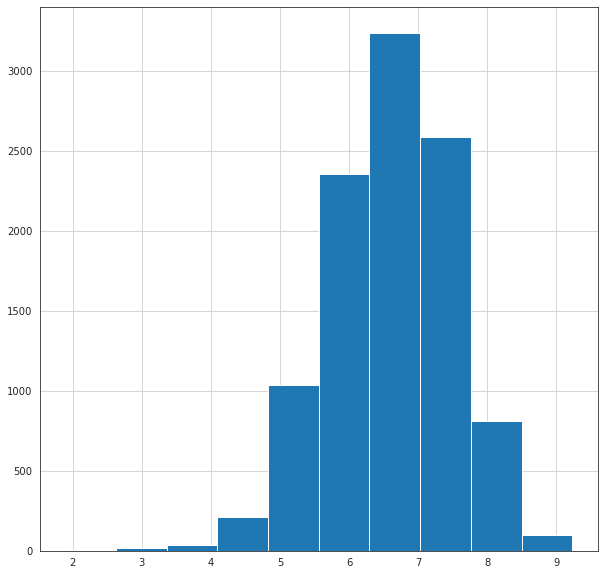

In [13]:
# Histogram
anime_db["rating"].hist(figsize=(10,10))

In [14]:
# Find the mean and standard deviation
average = anime_db["rating"].mean()
standard_dev = anime_db["rating"].std()

# Print the mean and standard deviation
print(f"Mean: {average:.2f}")
print(f"Standard Deviation: {standard_dev:.2f}")

# Print outlier counts
print("Total titles below 3 standard deviations:")
print(anime_db[anime_db["rating"] < (average - (standard_dev * 3))]["name"].count()) 
 
print("Total titles above 3 standard deviations:")                                                                                            
print(anime_db[anime_db["rating"] >= (average + (standard_dev * 3))]["name"].count())

Mean: 6.60
Standard Deviation: 0.89
Total titles below 3 standard deviations:
47
Total titles above 3 standard deviations:
0


<AxesSubplot:>

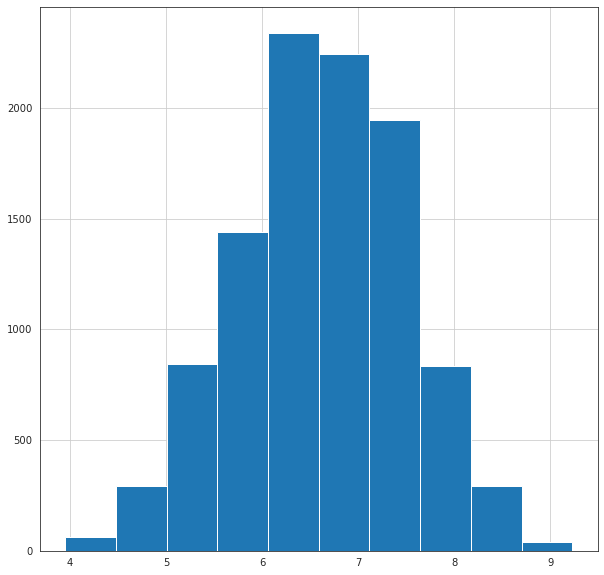

In [15]:
# Drop titles below 3 standard deviations from the mean and reprint the histogram
anime_db = anime_db.drop(anime_db[anime_db["rating"] <= (average - (standard_dev * 3))].index)

# Histogram
anime_db["rating"].hist(figsize=(10,10))

## Members vs Rating

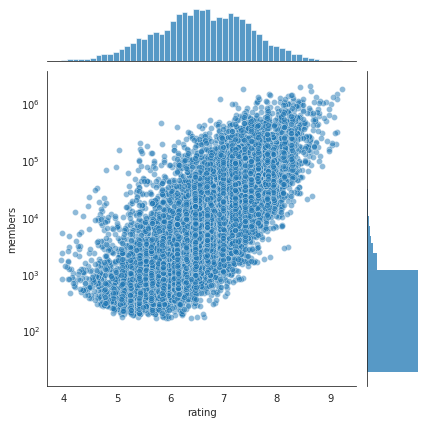

In [16]:
sns.jointplot(x='rating',y='members',data=anime_db,alpha=0.5)
plt.yscale('log')

the ratings seem to be linearly dependent on the (log) number of members. Seems logical: the more popular an anime is, the more members will add it to thieir list, and thus would score. Thus we can add missing ratings, based on the number of members. let's derive a linear model.

#### Linear model of members and ratings

 Let's create two datasets: 
 1. with ratings
 2. without ratings

In [17]:
without_rating = anime_db[anime_db["rating"].isnull()]
without_rating = without_rating.reset_index(drop=True)
without_rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5046 entries, 0 to 5045
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   name          5046 non-null   object 
 1   english_name  868 non-null    object 
 2   type          5046 non-null   object 
 3   episodes      4676 non-null   float64
 4   members       5046 non-null   float64
 5   rating        0 non-null      float64
 6   genre         5046 non-null   object 
 7   dates         5046 non-null   object 
 8   url           5046 non-null   object 
dtypes: float64(3), object(6)
memory usage: 354.9+ KB


In [18]:
with_rating = anime_db.dropna(subset=['rating'])
with_rating = with_rating.reset_index(drop=True)
with_rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10348 entries, 0 to 10347
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   name          10348 non-null  object 
 1   english_name  3963 non-null   object 
 2   type          10348 non-null  object 
 3   episodes      10280 non-null  float64
 4   members       10348 non-null  float64
 5   rating        10348 non-null  float64
 6   genre         10348 non-null  object 
 7   dates         10348 non-null  object 
 8   url           10348 non-null  object 
dtypes: float64(3), object(6)
memory usage: 727.7+ KB


In [19]:
with_rating['members'].values.reshape(-1, 1)

array([[ 3655.],
       [81251.],
       [ 5726.],
       ...,
       [ 3272.],
       [  207.],
       [  362.]])

In [20]:
# now create a linear model using the with_ratings data

from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(np.log10(with_rating['members'].values.reshape(-1, 1)),with_rating['rating'])

LinearRegression()

In [21]:
without_rating['members_copy'] = without_rating['members']

In [22]:
without_rating['members_copy'].replace([0],[1],inplace=True)

In [23]:
without_rating['rating'] = lm.predict(np.log10(without_rating['members_copy'].values.reshape(-1,1)))
without_rating.describe()

,episodes,members,rating,members_copy
count,4676.000000,5046.000000,5046.000000,5046.000000
mean,12.733319,1079.077883,5.527446,1079.077883
std,65.381088,7753.222516,0.332500,7753.222516
min,1.000000,19.000000,4.768075,19.000000
25%,1.000000,119.000000,5.339304,119.000000
50%,1.000000,186.000000,5.478360,186.000000
75%,8.000000,297.000000,5.624067,297.000000
max,3057.000000,217776.000000,7.678196,217776.000000


In [24]:
without_rating = without_rating.drop("members_copy",axis=1)

In [25]:
without_rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5046 entries, 0 to 5045
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   name          5046 non-null   object 
 1   english_name  868 non-null    object 
 2   type          5046 non-null   object 
 3   episodes      4676 non-null   float64
 4   members       5046 non-null   float64
 5   rating        5046 non-null   float64
 6   genre         5046 non-null   object 
 7   dates         5046 non-null   object 
 8   url           5046 non-null   object 
dtypes: float64(3), object(6)
memory usage: 354.9+ KB


In [26]:
# for future reference I will add a new parameter that indicates if the ratings were modelled

without_rating['rating_type'] = "modelled"
with_rating['rating_type'] = "MAL"

In [27]:
with_rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10348 entries, 0 to 10347
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   name          10348 non-null  object 
 1   english_name  3963 non-null   object 
 2   type          10348 non-null  object 
 3   episodes      10280 non-null  float64
 4   members       10348 non-null  float64
 5   rating        10348 non-null  float64
 6   genre         10348 non-null  object 
 7   dates         10348 non-null  object 
 8   url           10348 non-null  object 
 9   rating_type   10348 non-null  object 
dtypes: float64(3), object(7)
memory usage: 808.6+ KB


In [28]:
without_rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5046 entries, 0 to 5045
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   name          5046 non-null   object 
 1   english_name  868 non-null    object 
 2   type          5046 non-null   object 
 3   episodes      4676 non-null   float64
 4   members       5046 non-null   float64
 5   rating        5046 non-null   float64
 6   genre         5046 non-null   object 
 7   dates         5046 non-null   object 
 8   url           5046 non-null   object 
 9   rating_type   5046 non-null   object 
dtypes: float64(3), object(7)
memory usage: 394.3+ KB


In [29]:
anime_db = pd.concat([without_rating, with_rating])
anime_db = anime_db.reset_index(drop=True)
anime_db.info()
anime_db.isnull().sum().sort_values(ascending=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15394 entries, 0 to 15393
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   name          15394 non-null  object 
 1   english_name  4831 non-null   object 
 2   type          15394 non-null  object 
 3   episodes      14956 non-null  float64
 4   members       15394 non-null  float64
 5   rating        15394 non-null  float64
 6   genre         15394 non-null  object 
 7   dates         15394 non-null  object 
 8   url           15394 non-null  object 
 9   rating_type   15394 non-null  object 
dtypes: float64(3), object(7)
memory usage: 1.2+ MB


english_name    10563
episodes          438
name                0
type                0
members             0
rating              0
genre               0
dates               0
url                 0
rating_type         0
dtype: int64

In [30]:
anime_db.head()

,name,english_name,type,episodes,members,rating,genre,dates,url,rating_type
0,It's Marey O'Clock Now!,NaN,Movie,1.0,56.0,5.104617,['Dementia'],Oct 2018 - Oct 2018,https://myanimelist.net/anime/41489/Its_Marey_...,modelled
1,It's Show Time!,NaN,Music,1.0,135.0,5.378581,['Music'],Feb 2019 - Feb 2019,https://myanimelist.net/anime/39224/Its_Show_Time,modelled
2,Itazura Post,NaN,Movie,1.0,255.0,5.576596,['Comedy'],Jul 1917 - Jul 1917,https://myanimelist.net/anime/23183/Itazura_Post,modelled
3,Itazura Tenshi Chippo-chan,NaN,TV,240.0,216.0,5.524917,"['Comedy', 'Kids']",Mar 1970 - Dec 1970,https://myanimelist.net/anime/20025/Itazura_Te...,modelled
4,Itekoma Hits,NaN,Music,1.0,83.0,5.227130,"['Music', 'Dementia', 'Psychological']",Jun 2019 - Jun 2019,https://myanimelist.net/anime/40598/Itekoma_Hits,modelled


In [31]:
anime_db.tail()

,name,english_name,type,episodes,members,rating,genre,dates,url,rating_type
15389,Aoi Sekai no Chuushin de,World War Blue,Special,3.0,39823.0,5.84,"['Action', 'Adventure', 'Ecchi', 'Fantasy', 'P...",Oct 2012 - Apr 2013,https://myanimelist.net/anime/15133/Aoi_Sekai_...,MAL
15390,Big Order,NaN,OVA,1.0,30458.0,5.85,"['Action', 'Super Power', 'Shounen']",Oct 2015 - Oct 2015,https://myanimelist.net/anime/30137/Big_Order,MAL
15391,"Boku no Imouto wa ""Osaka Okan"": Uchi no Oniich...",NaN,Special,1.0,3272.0,5.85,['Comedy'],Apr 2013 - Apr 2013,https://myanimelist.net/anime/18419/Boku_no_Im...,MAL
15392,Daitan Futeki ni Koi Shitai,NaN,Music,1.0,207.0,5.85,['Music'],Nov 2018 - Nov 2018,https://myanimelist.net/anime/38487/Daitan_Fut...,MAL
15393,Dededen,NaN,Special,5.0,362.0,5.84,['Slice of Life'],Feb 2015 - Dec 2015,https://myanimelist.net/anime/30289/Dededen,MAL


In [32]:
anime_db.to_csv("./data/MAL_update_rating.csv")

In [33]:
# anime_db = pd.read_csv("../data/MAL_update_rating.csv")

### More data pre processing

Further data pre-processing:

1. Check and fix the 'types' column
2. Check for missing data in the genre. In some cases the genre just returned an empty '[]'
3. create dummy features for the genres and type features


In [34]:
# uniqe values in the 'type' column
anime_db['type'].unique()

array(['Movie', 'Music', 'TV', 'OVA', 'ONA', 'Special', 'Unknown'],
      dtype=object)

probably shuld chnage "unknown" to Unknown_type

In [35]:
anime_db['type'].replace("Unknown","Unknown_type",inplace=True)
anime_db['type'].unique()

array(['Movie', 'Music', 'TV', 'OVA', 'ONA', 'Special', 'Unknown_type'],
      dtype=object)

In [36]:
# look for empty '[]' in the genre column
sum(anime_db.genre.str.match('\[(.+)\]') == False)

68

In [37]:
anime_db[anime_db.genre.str.match('\[(.+)\]') == False]

,name,english_name,type,episodes,members,rating,genre,dates,url,rating_type
78,Scripta Volant,Writings Fly Away,Movie,1.0,143.0,5.396505,[],2011 - 2011,https://myanimelist.net/anime/33318/Scripta_Vo...,modelled
102,Mabeob Chunjamun: Daemawang-ui Buhwal-eul Mag-ala,NaN,Movie,1.0,104.0,5.297355,[],2010 - 2010,https://myanimelist.net/anime/30055/Mabeob_Chu...,modelled
315,Ichi-gan Kuni,NaN,Movie,1.0,103.0,5.294347,[],2009 - 2009,https://myanimelist.net/anime/31509/Ichi-gan_Kuni,modelled
341,Ikite Iru,NaN,OVA,1.0,95.0,5.269173,[],1996 - 1996,https://myanimelist.net/anime/28487/Ikite_Iru,modelled
372,Hello WeGo!,NaN,Movie,1.0,363.0,5.686546,[],Mar 2019 - Mar 2019,https://myanimelist.net/anime/38011/Hello_WeGo,modelled
...,...,...,...,...,...,...,...,...,...,...
11076,Match Shoujo,The Little Match Girl,ONA,1.0,753.0,5.770000,[],Feb 2016 - Feb 2016,https://myanimelist.net/anime/32695/Match_Shoujo,MAL
11503,Katsudou Shashin,NaN,Movie,1.0,3960.0,5.470000,[],-,https://myanimelist.net/anime/33187/Katsudou_S...,MAL
12328,Hokori Inu no Hanashi,The Cloudy Dog Talk About,ONA,1.0,238.0,5.650000,[],Feb 2013 - Feb 2013,https://myanimelist.net/anime/32636/Hokori_Inu...,MAL
13039,Mormorando,NaN,Movie,1.0,408.0,5.400000,[],Sep 2014 - Sep 2014,https://myanimelist.net/anime/31834/Mormorando,MAL


This data seems incomplete. In the future we'll want to verify this dataset is up to date. For now, I'll label these genres unknown_genre

In [38]:
anime_db['genre'].replace('[]', '[unknown_genre]', inplace=True)

In [39]:
sum(anime_db.genre.str.match('\[(.+)\]') == False)

0

### Genre

Now that we have sorted the missing data and did some conversions, we need to select our features. Planning to use: genre, type and rating as the feature space

Let's filter out any unnecessary characters from the genre field for ease of use.

In [40]:
anime_db = anime_db.reset_index(drop = True)

In [41]:
anime_db.genre[0]

"['Dementia']"

In [42]:
anime_db.shape
anime_db.count()

name            15394
english_name     4831
type            15394
episodes        14956
members         15394
rating          15394
genre           15394
dates           15394
url             15394
rating_type     15394
dtype: int64

In [43]:
g = list()
for e in anime_db.genre[15390].split(","):
    l = [x for x in e if x not in "[]"]
    print(l)
    g.append("".join(x for x in l if x not in "'‘ ’ '"))
g

["'", 'A', 'c', 't', 'i', 'o', 'n', "'"]
[' ', "'", 'S', 'u', 'p', 'e', 'r', ' ', 'P', 'o', 'w', 'e', 'r', "'"]
[' ', "'", 'S', 'h', 'o', 'u', 'n', 'e', 'n', "'"]


['Action', 'SuperPower', 'Shounen']

In [44]:
g = list()
for e in anime_db.genre[0].split(","):
    l = [x for x in e if x not in "[]"]
    print(l)
    g.append("".join(x for x in l if x not in "'‘ ’ '"))
g

["'", 'D', 'e', 'm', 'e', 'n', 't', 'i', 'a', "'"]


['Dementia']

In [45]:
for i in range(0,anime_db.shape[0]):
    g = list()
    for e in anime_db.genre[i].split(","):
        l = [x for x in e if x not in "[]"]
        g.append("".join(x for x in l if x not in "'‘ ’ '"))
    anime_db.genre[i] = g

/tmp/ipykernel_116/1215244638.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anime_db.genre[i] = g


In [46]:
anime_db.genre.tail(100)

15294                               [Action, Mecha, Music]
15295                                      [Music, School]
15296                              [Action, Sci-Fi, Mecha]
15297           [Comedy, Parody, Romance, School, Shounen]
15298                                      [Music, Demons]
                               ...                        
15389    [Action, Adventure, Ecchi, Fantasy, Parody, Sh...
15390                        [Action, SuperPower, Shounen]
15391                                             [Comedy]
15392                                              [Music]
15393                                        [SliceofLife]
Name: genre, Length: 100, dtype: object

In [47]:
anime_db.genre[0]

['Dementia']

## Generate features

Good now with the genere colum fixed, we can create the list of features for our classifier.


In [48]:
# save the dataset
anime_db.to_csv("./data/MAL_final.csv",index=False)


In [49]:
pd.get_dummies(anime_db.genre.apply(pd.Series).stack()).groupby(level=0).sum()

,Action,Adventure,Cars,Comedy,Dementia,Demons,Drama,Ecchi,Fantasy,Game,...,SliceofLife,Space,Sports,SuperPower,Supernatural,Thriller,Vampire,Yaoi,Yuri,unknown_genre
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15389,1,1,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
15390,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
15391,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15392,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [50]:
anime_features = pd.concat([pd.get_dummies(anime_db.genre.apply(pd.Series).stack()).groupby(level=0).sum(),
                            pd.get_dummies(anime_db['type']),anime_db.rating],axis=1)

In [51]:
anime_features.shape

(15394, 51)

In [52]:
pd.options.display.max_columns = 99
anime_features.head()

,Action,Adventure,Cars,Comedy,Dementia,Demons,Drama,Ecchi,Fantasy,Game,Harem,Historical,Horror,Josei,Kids,Magic,MartialArts,Mecha,Military,Music,Mystery,Parody,Police,Psychological,Romance,Samurai,School,Sci-Fi,Seinen,Shoujo,ShoujoAi,Shounen,ShounenAi,SliceofLife,Space,Sports,SuperPower,Supernatural,Thriller,Vampire,Yaoi,Yuri,unknown_genre,Movie,Music,ONA,OVA,Special,TV,Unknown_type,rating
0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,5.104617
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,5.378581
2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,5.576596
3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,5.524917
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,5.227130


In [53]:
anime_db.head()

,name,english_name,type,episodes,members,rating,genre,dates,url,rating_type
0,It's Marey O'Clock Now!,NaN,Movie,1.0,56.0,5.104617,[Dementia],Oct 2018 - Oct 2018,https://myanimelist.net/anime/41489/Its_Marey_...,modelled
1,It's Show Time!,NaN,Music,1.0,135.0,5.378581,[Music],Feb 2019 - Feb 2019,https://myanimelist.net/anime/39224/Its_Show_Time,modelled
2,Itazura Post,NaN,Movie,1.0,255.0,5.576596,[Comedy],Jul 1917 - Jul 1917,https://myanimelist.net/anime/23183/Itazura_Post,modelled
3,Itazura Tenshi Chippo-chan,NaN,TV,240.0,216.0,5.524917,"[Comedy, Kids]",Mar 1970 - Dec 1970,https://myanimelist.net/anime/20025/Itazura_Te...,modelled
4,Itekoma Hits,NaN,Music,1.0,83.0,5.227130,"[Music, Dementia, Psychological]",Jun 2019 - Jun 2019,https://myanimelist.net/anime/40598/Itekoma_Hits,modelled


In [54]:
anime_db.tail(10)

,name,english_name,type,episodes,members,rating,genre,dates,url,rating_type
15384,Sweet Valerian Specials,NaN,Special,8.0,803.0,5.86,"[Comedy, Magic, Shoujo]",Jun 2005 - Sep 2005,https://myanimelist.net/anime/3863/Sweet_Valer...,MAL
15385,Tonari no 801-chan R,NaN,OVA,1.0,2614.0,5.85,"[Comedy, Music]",Sep 2009 - Sep 2009,https://myanimelist.net/anime/6641/Tonari_no_8...,MAL
15386,Ys IV: The Dawn of Ys,NaN,Special,1.0,561.0,5.86,"[Action, Adventure, Fantasy, Game]",1993 - 1993,https://myanimelist.net/anime/23825/Ys_IV__The...,MAL
15387,Aesop's World,NaN,TV,26.0,454.0,5.85,[Kids],Apr 1999 - Dec 1999,https://myanimelist.net/anime/4709/Aesops_World,MAL
15388,Animegatari,NaN,Movie,8.0,3793.0,5.84,[Comedy],Apr 2015 - Mar 2016,https://myanimelist.net/anime/30617/Animegatari,MAL
15389,Aoi Sekai no Chuushin de,World War Blue,Special,3.0,39823.0,5.84,"[Action, Adventure, Ecchi, Fantasy, Parody, Sh...",Oct 2012 - Apr 2013,https://myanimelist.net/anime/15133/Aoi_Sekai_...,MAL
15390,Big Order,NaN,OVA,1.0,30458.0,5.85,"[Action, SuperPower, Shounen]",Oct 2015 - Oct 2015,https://myanimelist.net/anime/30137/Big_Order,MAL
15391,"Boku no Imouto wa ""Osaka Okan"": Uchi no Oniich...",NaN,Special,1.0,3272.0,5.85,[Comedy],Apr 2013 - Apr 2013,https://myanimelist.net/anime/18419/Boku_no_Im...,MAL
15392,Daitan Futeki ni Koi Shitai,NaN,Music,1.0,207.0,5.85,[Music],Nov 2018 - Nov 2018,https://myanimelist.net/anime/38487/Daitan_Fut...,MAL
15393,Dededen,NaN,Special,5.0,362.0,5.84,[SliceofLife],Feb 2015 - Dec 2015,https://myanimelist.net/anime/30289/Dededen,MAL


In [55]:
#remove special characters from the names
anime_db["name"] = anime_db["name"].map(lambda name:re.sub('[^A-Za-z0-9]+', " ", name))

## recommendation system

For the recommendations I will use the simple k-means, to find the nearest x entries

In [56]:
#use MaxBsScaler to scale the features from 1-0, while preserving sparsity
from sklearn.preprocessing import MaxAbsScaler
max_abs_scaler = MaxAbsScaler()
anime_features = max_abs_scaler.fit_transform(anime_features)

In [57]:
#build a model using the unsupervised verion of K-Nearest Neighbors
from sklearn.neighbors import NearestNeighbors

In [64]:
nn_model = NearestNeighbors(n_neighbors=6,algorithm='auto').fit(anime_features)

In [65]:
#Obtain the indices of and distances to the the nearest K neighbors of each point.
distances, indices = nn_model.kneighbors(anime_features)

In [66]:
# take a look at one of the idices

indices.shape

(15394, 6)

In [67]:
def similar_anime_content(query):
    if query not in anime_db['name']:
        N = anime_db[anime_db['name'].str.upper() == query.upper()].index[0]
        print(N)
        print('Similar Anime to "{}":'.format(query))
        for n in indices[N]:
            if query not in anime_db.loc[n]['name']:
                print('Anime: {} ({}) \n Genre: {}; Average ratings: {}; Format: {}, Members: {}'.format(anime_db.loc[n]['name'],                     
                                                                                      anime_db.loc[n]['english_name'],
                                                                                      anime_db.loc[n]['genre'],
                                                                                      round(anime_db.loc[n]['rating'],2),
                                                                                      anime_db.loc[n]['type'],
                                                                                      anime_db.loc[n]['members']
                                                                                      ))        
    else:
        print('The anime {} does not exist in our database.'.format(query))

In [68]:
test_anime = 1912
distance, index = nn_model.kneighbors(anime_features[test_anime].reshape(1,-1))

In [69]:
# Accuracy will be determined by the distance from the original anime
def accuracy(x, min_val):
   return (1 - (abs(x - min_val))) * 100 

# Calculate the shortest distance to any element
min_val = np.min(distances)

# Determine average accuracy and worst accuracy
distance_average = np.mean(distances)
distance_max_val = np.max(distances)

print("Average Accuracy: ", accuracy(distance_average, min_val))
print("Worst Accuracy: ", accuracy(distance_max_val, min_val))

print(anime_db.iloc[test_anime].loc["name"], "Accuracy List")
for x in range(1,5):
    print(anime_db.iloc[index[0,x]].loc["name"],"Accuracy:", accuracy(distance[0,x], min_val), "%")

Average Accuracy:  57.376516475351465
Worst Accuracy:  -200.00706232074285
Kaze Gourmet Accuracy List
Kaze Gourmet Accuracy: 100.0 %
Ojiichan no Komoriuta Accuracy: 100.0 %
Chiisana Tegami Accuracy: 100.0 %
Kumo ga Haretara Accuracy: 99.97438781192307 %


In [70]:
# random anime
from random import randint, sample
def randomAnime():
    R = sample(range(0, len(anime_db)-1), 1)
    rand_anime = anime_db.loc[R]
    print('Random Anime: {}; Genre: {}'.format(rand_anime['name'].to_string(index=False),rand_anime['genre'].to_string(index=False)))

In [71]:
randomAnime()

Random Anime: Memories Off 3 5; Genre: [Romance, Drama]


In [72]:
similar_anime_search = widgets.Text()
similar_anime_output = widgets.Output()
similar_anime_button = widgets.Button(
    description='Submit',
    disabled=False,
    button_style='',
    tooltip='Submit'
)
display(similar_anime_search, similar_anime_button, similar_anime_output)
def search_similar_anime(text_field, button):
    with similar_anime_output:
        similar_anime_output.clear_output()
        similar_anime_content(text_field.value)
        
similar_anime_button.on_click(partial(search_similar_anime,similar_anime_search)) 

Text(value='')

Button(description='Submit', style=ButtonStyle(), tooltip='Submit')

Output()

In [73]:
button = widgets.Button(
    description='Random Anime',
    disabled=False,
    button_style='',
    tooltip='Random Anime'
)
output = widgets.Output()

display(button, output)
def on_button_click(b):
    with output:
        output.clear_output()
        randomAnime()
button.on_click(on_button_click)

Button(description='Random Anime', style=ButtonStyle(), tooltip='Random Anime')

Output()